<a href="https://colab.research.google.com/github/tylerlum/ufc_automated_scoring_system/blob/main/UFC_Automated_Scoring_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFC Automated Scoring System

The goal of this notebook is to:
* Explore the FightMetrics webpage to scrape the fight and fighter information we need
* Store the fight and fighter data into csv files
* Preprocess the data
* Train and evaluate a neural network to predict fight outcomes

Still functional as of April 2021

## Set parameters for dataset creation

NUM_EVENTS: Integer number of UFC events to get fights from or "All" for all events. There are about 10 fights per event.

DATA_MODE: Either "Summary" or "Round by Round". Either get data with columns that are summaries of the whole fight, or summaries round-by-round (more columns).

In [1]:
NUM_EVENTS_INPUT = "All"  #@param {type:"string"}
DATA_MODE_INPUT = "Summary"  #@param {type:"string"}

In [2]:
NUM_EVENTS = None if NUM_EVENTS_INPUT == "All" else int(NUM_EVENTS_INPUT)
ROUND_BY_ROUND = (DATA_MODE_INPUT == "Round by Round")

## Get information about all fighters

TODO: Get more detailed information about fighters, so we can change the task to fight prediction using fighter stats only. http://ufcstats.com/statistics/fighters?char=a&page=all has little information compared to http://ufcstats.com/fighter-details/33a331684283900f.

In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import re

In [4]:
def get_all_fighters():
    '''Get pandas table of all UFC fighters (Name, Height, Weight, Reach, Record, etc.)'''
    from string import ascii_lowercase

    all_fighters_tables = []
    for c in tqdm(ascii_lowercase):
        all_fighters_url = f"http://ufcstats.com/statistics/fighters?char={c}&page=all"
        all_fighters_table = pd.read_html(all_fighters_url)[0]
        all_fighters_tables.append(all_fighters_table)

    all_fighters = pd.concat(all_fighters_tables)
    return all_fighters

In [5]:
ALL_FIGHTERS = get_all_fighters()
ALL_FIGHTERS.head()

100%|██████████| 26/26 [00:32<00:00,  1.26s/it]


,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN
2,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN
4,Shamil,Abdurakhimov,Abrek,"6' 3""",235 lbs.,"76.0""",Orthodox,20.0,5.0,0.0,NaN


In [6]:
ALL_FIGHTERS.dtypes

First        object
Last         object
Nickname     object
Ht.          object
Wt.          object
Reach        object
Stance       object
W           float64
L           float64
D           float64
Belt        float64
dtype: object

## Clean fighter data

TODO: Convert height, weight, reach to floats.

In [7]:
ALL_FIGHTERS = ALL_FIGHTERS.replace("^-+", np.nan, regex=True)  # Replace -- and --- with nan
ALL_FIGHTERS.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tom,Aaron,NaN,NaN,155 lbs.,NaN,NaN,5.0,3.0,0.0,NaN
2,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,NaN,Orthodox,4.0,6.0,0.0,NaN
3,David,Abbott,Tank,"6' 0""",265 lbs.,NaN,Switch,10.0,15.0,0.0,NaN
4,Shamil,Abdurakhimov,Abrek,"6' 3""",235 lbs.,"76.0""",Orthodox,20.0,5.0,0.0,NaN


## Helper functions

In [8]:
def get_fighters(fighters_string):
    '''Parses string containing two fighter names. Uses ALL_FIGHTERS global to remove ambiguity in parsing. Returns each fighter name
       Eg. "Robert Whittaker Kelvin Gastelum" => ("Robert Whittaker", "Kelvin Gastelum")'''
    for i, row in ALL_FIGHTERS.iterrows():
        fighter_name = f'{row["First"]} {row["Last"]}'
        if fighters_string.startswith(fighter_name):
            first_fighter = fighter_name
            second_fighter = fighters_string[len(fighter_name)+1:]
            break
    return first_fighter, second_fighter

def remove_duplicates_keep_order(list_):
    '''Removes duplicates while keeping same order'''
    return list(dict.fromkeys(list_))

## Get a list of all UFC events

In [9]:
from urllib.request import urlopen
from string import ascii_uppercase
from dateutil import parser
from datetime import datetime

In [10]:
ALL_PAST_EVENTS_URL = "http://ufcstats.com/statistics/events/completed?page=all"

In [11]:
def get_all_events(all_past_events_url):
    '''Takes in URL to all past events. Returns list of urls, each one representing a UFC event'''
    all_past_events_html = urlopen(all_past_events_url).read().decode("utf-8")
    
    # Regex for "http://ufcstats.com/events-details/<alphanumeric>"
    # Eg. "http://ufcstats.com/event-details/27541033b97c076d"
    pattern = "\"http://ufcstats.com/event-details/[a-zA-Z0-9_]+\""
    all_urls = re.findall(pattern, all_past_events_html)

    # Remove quotes and duplicates
    all_urls = [url.strip("\"") for url in all_urls]
    all_urls = remove_duplicates_keep_order(all_urls)
    return all_urls

In [12]:
# Events
ALL_EVENT_URLS = get_all_events(ALL_PAST_EVENTS_URL)
print(f"Got {len(ALL_EVENT_URLS)} events")
print()

print("Removing the most recent event, since it might not have happened yet")
ALL_EVENT_URLS = ALL_EVENT_URLS[1:]
print(f"Now got {len(ALL_EVENT_URLS)} events")
print(ALL_EVENT_URLS)

Got 559 events

Removing the most recent event, since it might not have happened yet
Now got 558 events
['http://ufcstats.com/event-details/4a35913bd9aa4161', 'http://ufcstats.com/event-details/9114c8ded5ccd71d', 'http://ufcstats.com/event-details/6597b611f1c32555', 'http://ufcstats.com/event-details/c36e1f4fa755ffb4', 'http://ufcstats.com/event-details/8c90c1563972e44d', 'http://ufcstats.com/event-details/6e2b1d631832921d', 'http://ufcstats.com/event-details/81b57acd6975ac06', 'http://ufcstats.com/event-details/bfe95ec546692b13', 'http://ufcstats.com/event-details/3f7c14c7eca7195d', 'http://ufcstats.com/event-details/a1153013cb5f628f', 'http://ufcstats.com/event-details/4304992c2acc187b', 'http://ufcstats.com/event-details/56116537d71a578c', 'http://ufcstats.com/event-details/307064d3e0f036c2', 'http://ufcstats.com/event-details/e49c2db95e572dc8', 'http://ufcstats.com/event-details/d0d43cb9b14f231c', 'http://ufcstats.com/event-details/398b440e73d55b8b', 'http://ufcstats.com/event-deta

## Get a list of UFC fights

TODO: Right now only sees if result is win. Else sets winner to None. See if this can be improved.

In [13]:
def get_all_fights_in_event(past_event_url, get_results=False):
    '''Takes in a single URL to a past event.
       If get_results=True, returns fight_urls, winners, methods
       else, return fight_urls'''
    # Regex for "http://ufcstats.com/events-details/<alphanumeric>"
    # Eg. "http://ufcstats.com/fight-details/f67aa0b16e16a9ea"
    past_event_html = urlopen(past_event_url).read().decode("utf-8")
    pattern = "\"http://ufcstats.com/fight-details/[a-zA-Z0-9_]+\""
    fight_urls = re.findall(pattern, past_event_html)

    # Remove quotes and duplicates
    fight_urls = [url.strip("\"") for url in fight_urls]
    fight_urls = remove_duplicates_keep_order(fight_urls)

    # Get the winner and method (dec or KO or sub) of each fight
    past_event_table = pd.read_html(past_event_url)[0]  # Will be length 1 list
    winners, methods = [], []
    for _, row in past_event_table.iterrows():
        # TODO: Improve this processing of result
        result = row["W/L"].split(' ')[0]
        if result == "win":
            winner, _ = get_fighters(row["Fighter"])
        else:
            winner = None
        winners.append(winner)
        methods.append(row["Method"])

    if get_results:
        return fight_urls, winners, methods
    else:
        return fight_urls

In [14]:
def get_all_fights(all_event_urls, num_events=None):
    '''Takes in list of URLs to past events. Returns 3 lists: urls, winners, methods, each representing a UFC fight.
       Set num_events to be the number of events to get fights from. Set to None if want all.'''
    if num_events is None:
        num_events = len(all_event_urls)
    
    all_fight_urls, all_winners, all_methods = [], [], []
    for i, event_url in enumerate(tqdm(all_event_urls[:num_events])):
        # For each event, get the fight urls and winners
        fight_urls, winners, methods = get_all_fights_in_event(event_url, get_results=True)
        all_fight_urls.extend(fight_urls)
        all_winners.extend(winners)
        all_methods.extend(methods)
    return all_fight_urls, all_winners, all_methods

In [15]:
FIGHT_URLS, WINNERS, METHODS = get_all_fights(ALL_EVENT_URLS, num_events=NUM_EVENTS)
print(f"Got {len(FIGHT_URLS)} fights")
print(FIGHT_URLS)
print(WINNERS)
print(METHODS)

assert(len(FIGHT_URLS) == len(WINNERS))
assert(len(FIGHT_URLS) == len(METHODS))

100%|██████████| 558/558 [20:01<00:00,  2.15s/it]

Got 6066 fights
['http://ufcstats.com/fight-details/f67aa0b16e16a9ea', 'http://ufcstats.com/fight-details/f2c82f027201ba21', 'http://ufcstats.com/fight-details/a850ba762f3c5334', 'http://ufcstats.com/fight-details/0b2c3c4306620d6d', 'http://ufcstats.com/fight-details/a33ecd2c88154890', 'http://ufcstats.com/fight-details/fdfe4e7cb2d0b665', 'http://ufcstats.com/fight-details/25d4376e00b16510', 'http://ufcstats.com/fight-details/627c0a50cff30405', 'http://ufcstats.com/fight-details/8d634c9240f161dd', 'http://ufcstats.com/fight-details/24ff385ca78c80d3', 'http://ufcstats.com/fight-details/ddd63237f1b857a6', 'http://ufcstats.com/fight-details/71b81d8199a0fa19', 'http://ufcstats.com/fight-details/646eeca9447c6965', 'http://ufcstats.com/fight-details/0992795fd0fa06d0', 'http://ufcstats.com/fight-details/ac9a8b73e58f3d71', 'http://ufcstats.com/fight-details/e27c28928ed4390f', 'http://ufcstats.com/fight-details/998296216e7171ed', 'http://ufcstats.com/fight-details/7aebf01b5afc0109', 'http://ufc

## Get fight tables


In [16]:
def get_labeled_fight_tables(fight_url):
    '''Convert fight url to dictionary of pandas tables of information.
       Before, gave a list of tables that was hard to understand.
       Now have Totals, Per Round Totals, Significant Strikes, Per Round Significant Strikes'''
    fight_tables = pd.read_html(fight_url)
    
    labeled_fight_tables = {}
    labeled_fight_tables['Totals'] = fight_tables[0]
    labeled_fight_tables['Per Round Totals'] = fight_tables[1]
    labeled_fight_tables['Significant Strikes'] = fight_tables[2]
    labeled_fight_tables['Per Round Significant Strikes'] = fight_tables[3]
    return labeled_fight_tables

In [17]:
RAW_FIGHT_TABLES_LIST = []
for url in tqdm(FIGHT_URLS):
    RAW_FIGHT_TABLES_LIST.append(get_labeled_fight_tables(url))

 97%|█████████▋| 5893/6066 [1:21:38<01:55,  1.49it/s]

ImportError: BeautifulSoup4 (bs4) not found, please install it

In [18]:
RAW_FIGHT_TABLES_LIST[0]['Totals'].head()

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Rev.,Ctrl
0,Robert Whittaker Kelvin Gastelum,0 0,150 of 284 62 of 209,52% 29%,169 of 303 70 of 218,4 of 7 1 of 5,57% 20%,0 0,0 0,4:19 0:26


In [19]:
RAW_FIGHT_TABLES_LIST[0]['Per Round Totals'].head()

Fighter      KD           Sig. str. Sig. str. %  \
                            Round 1 Round 1             Round 1     Round 1   
                            Round 2 Round 2             Round 2     Round 2   
                            Round 3 Round 3             Round 3     Round 3   
                            Round 4 Round 4             Round 4     Round 4   
                            Round 5 Round 5             Round 5     Round 5   
0  Robert Whittaker Kelvin Gastelum    0  0   18 of 42  8 of 19    42%  42%   
1  Robert Whittaker Kelvin Gastelum    0  0  43 of 74  14 of 61    58%  22%   
2  Robert Whittaker Kelvin Gastelum    0  0  38 of 64  20 of 57    59%  35%   
3  Robert Whittaker Kelvin Gastelum    0  0  33 of 71  13 of 43    46%  30%   
4  Robert Whittaker Kelvin Gastelum    0  0   18 of 33  7 of 29    54%  24%   

           Total str.            Td %            Sub. att    Rev.        Ctrl  
              Round 1         Round 1             Round 1 Round 1     Round 1  
              Round 2         Round 2             Round 2 Round 2     Round 2  
              Round 3         Round 3             Round 3 Round 3     Round 3  
              Round 4         Round 4             Round 4 Round 4     Round 4  
              Round 5         Round 5  Round 5.1  Round 5 Round 5     Round 5  
0   33 of 57  8 of 19  1 of 1  0 of 0  100%  ---     0  0    0  0  2:28  0:00  
1  44 of 75  16 of 63  1 of 1  0 of 2   100%  0%     0  0    0  0  0:06  0:13  
2  38 of 64  20 of 57  0 of 1  0 of 0    0%  ---     0  0    0  0  0:00  0:00  
3  33 of 71  13 of 43  0 of 1  1 of 3    0%  33%     0  0    0  0  0:00  0:02  
4  21 of 36  13 of 36  2 of 3  0 of 0   66%  ---     0  0    0  0  1:45  0:11

In [20]:
RAW_FIGHT_TABLES_LIST[0]['Significant Strikes'].head()

,Fighter,Sig. str,Sig. str. %,Head,Body,Leg,Distance,Clinch,Ground
0,Robert Whittaker Kelvin Gastelum,150 of 284 62 of 209,52% 29%,115 of 241 42 of 185,13 of 19 7 of 10,22 of 24 13 of 14,138 of 265 59 of 203,5 of 7 3 of 6,7 of 12 0 of 0


In [21]:
RAW_FIGHT_TABLES_LIST[0]['Per Round Significant Strikes'].head()

,Fighter,Sig. str,Sig. str. %,Head,Body,Leg,Distance,Clinch,Ground,Unnamed: 9_level_0
,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1
,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2
,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3
,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4
,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5
0,Robert Whittaker Kelvin Gastelum,18 of 42 8 of 19,42% 42%,16 of 38 3 of 13,0 of 1 1 of 2,2 of 3 4 of 4,14 of 34 8 of 19,0 of 0 0 of 0,4 of 8 0 of 0,NaN
1,Robert Whittaker Kelvin Gastelum,43 of 74 14 of 61,58% 22%,33 of 61 9 of 56,5 of 8 1 of 1,5 of 5 4 of 4,39 of 69 14 of 61,2 of 2 0 of 0,2 of 3 0 of 0,NaN
2,Robert Whittaker Kelvin Gastelum,38 of 64 20 of 57,59% 35%,27 of 53 12 of 47,6 of 6 3 of 4,5 of 5 5 of 6,36 of 61 20 of 55,2 of 3 0 of 2,0 of 0 0 of 0,NaN
3,Robert Whittaker Kelvin Gastelum,33 of 71 13 of 43,46% 30%,25 of 61 12 of 41,2 of 3 1 of 2,6 of 7 0 of 0,32 of 69 10 of 39,1 of 2 3 of 4,0 of 0 0 of 0,NaN
4,Robert Whittaker Kelvin Gastelum,18 of 33 7 of 29,54% 24%,14 of 28 6 of 28,0 of 1 1 of 1,4 of 4 0 of 0,17 of 32 7 of 29,0 of 0 0 of 0,1 of 1 0 of 0,NaN


## Clean fight information

Separate each fighter's information into a different column

TODO: Lots of stuff to improve. Smarter use of Totals, round by round, and significant strikes. Can also use non integer information, total attempted strikes (not just landed), fighter information, etc. All of those being ignored right now. Find nice way to parse new information round by round. Handle no winner case better. May need to add ignore_index=True for pd.concat

In [22]:
def parse_string(row_string):
    '''Break string into two parts: one for fighter 0 and one for fighter 1
       Eg. 150 of 284  62 of 209 => (150 of 284, 62 of 209)'''
    if not isinstance(row_string, str):
        print(f"row_string = {row_string} is not a string")
        return "0", "0"
    string_split = row_string.split(" ")
    first_fighter_stat = " ".join(string_split[:len(string_split)//2])
    second_fighter_stat = " ".join(string_split[len(string_split)//2+1:])
    return first_fighter_stat, second_fighter_stat

In [23]:
def convert_to_int_or_double_if_possible(string):
    '''Convert string to int or double if possible
       If has a percent sign, tries to remove it and continue.'''
    def isfloat(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # If input is not string, then return it unchanged
    if not isinstance(string, str):
        return string

    # Remove %
    if "%" in string:
        string = string.strip("%")

    # Convert to int or float
    if isfloat(string) and float(string).is_integer():
        return int(string)
    if isfloat(string):
        return float(string)
    return string

In [24]:
def process_fight(raw_fight_table):
    '''Takes in a raw, one-row pandas fight table. Returns a pandas dataframe representing the fight statistics'''    
    # Break up columns.
    # Eg. "Name" => "Fighter 0 Name", "Fighter 1 Name"
    # "KD" => "Fighter 0 KD", "Fighter 1 KD"
    new_columns = []
    for column in raw_fight_table.columns:
        new_columns.append(f"Fighter 0 {column}")
        new_columns.append(f"Fighter 1 {column}")

    # Go through each row and break up the data into the columns
    new_rows = []
    for i, row in raw_fight_table.iterrows():
        new_row = []
        for column in raw_fight_table.columns:
            # Split string at the center space
            stat1, stat2 = parse_string(row[column])

            # TODO: Update this to capture more information

            # Has "100 of 120" type stat. Just store first number
            if "of" in stat1:
                stat1 = stat1.split(" of ")[0]
                stat2 = stat2.split(" of ")[0]

            # Has "2:32" type stat (min:sec). Convert to sec.
            elif ":" in stat1:
                min1, sec1 = stat1.split(":")[0], stat1.split(":")[1]
                min2, sec2 = stat2.split(":")[0], stat2.split(":")[1]
                stat1 = convert_to_int_or_double_if_possible(min1)*60 + convert_to_int_or_double_if_possible(sec1)
                stat2 = convert_to_int_or_double_if_possible(min2)*60 + convert_to_int_or_double_if_possible(sec2)
            
            # Convert string to float or int if possible
            stat1 = convert_to_int_or_double_if_possible(stat1)
            stat2 = convert_to_int_or_double_if_possible(stat2)

            # Add to row
            new_row.append(stat1)
            new_row.append(stat2)
        new_rows.append(new_row)

    # Bring together into new dataframe, then only store the numerical values
    # TODO: Process better to keep more info, not throw so much away
    df = pd.DataFrame(new_rows, columns=new_columns)

    # Add in names, using smarter parsing
    df = df.drop(columns=['Fighter 0 Fighter', 'Fighter 1 Fighter'])
    fighters_string = raw_fight_table["Fighter"][0]  # Only 1 row table
    fighter0, fighter1 = get_fighters(fighters_string)
    df['Fighter 0 Name'] = fighter0
    df['Fighter 1 Name'] = fighter1
    return df

In [25]:
def process_raw_fight_tables(raw_fight_tables, winner, method, round_by_round=False):
    '''Takes in set of raw fight table (one fight), the name of the fight winner, and the method of winning. Returns a cleaned pandas table.
       Set round_by_round=True to use the round-by-round data. Otherwise, uses full fight stats.'''
    def create_aggregated_fight_table(raw_fight_tables):
        # Aggregate data from multiple tables
        fight_table = process_fight(raw_fight_tables["Totals"])
        fight_table2 = process_fight(raw_fight_tables["Significant Strikes"])
        
        # Rename column names with identical data to match
        fight_table2 = fight_table2.rename(columns={"Fighter 0 Sig. str": "Fighter 0 Sig. str.", "Fighter 1 Sig. str": "Fighter 1 Sig. str."})

        # Bring tables together, then remove duplicates
        fight_table = pd.concat([fight_table, fight_table2], axis=1)
        fight_table = fight_table.loc[:,~fight_table.columns.duplicated()]
        return fight_table

    def create_aggregated_round_by_round_fight_table(raw_fight_tables):
        ##### Aggregate data totals table
        tables = []
        for i, row in raw_fight_tables["Per Round Totals"].iterrows():
            # Get df of one round
            df = pd.DataFrame(row)
            values = list(df[i].to_dict().values())
            cols = list(raw_fight_tables["Totals"].columns)
            df = pd.DataFrame([values], columns=cols)

            # Update columns with round number
            new_cols = [f"Round {i+1} {c}" if c != "Fighter" else c for c in cols]
            df.columns = new_cols
            tables.append(process_fight(df))
        # Concatenate round-by-round horizontally, so each row is for 1 fight.
        # Then remove duplicates
        totals_df = pd.concat(tables, axis=1)
        totals_df = totals_df.loc[:,~totals_df.columns.duplicated()]

        ##### Aggregate data significant strikes table
        tables = []
        for i, row in raw_fight_tables["Per Round Significant Strikes"].iterrows():
            # Get df of one round
            df = pd.DataFrame(row)
            values = list(df[i].to_dict().values())
            cols = list(raw_fight_tables["Significant Strikes"].columns)
            if len(values) != len(cols):
                values = values[:-1]  # Remove last column values, as shown above, has extra column for no reason
            df = pd.DataFrame([values], columns=cols)

            # Update columns with round number
            new_cols = [f"Round {i+1} {c}" if c != "Fighter" else c for c in cols]
            df.columns = new_cols
            tables.append(process_fight(df))
        # Concatenate round-by-round horizontally, so each row is for 1 fight
        # Then remove duplicates
        sig_strikes_df = pd.concat(tables, axis=1)
        sig_strikes_df = sig_strikes_df.loc[:,~sig_strikes_df.columns.duplicated()]
        
        ##### Bring tables together, then remove duplicates
        fight_table = pd.concat([totals_df, sig_strikes_df], axis=1)
        fight_table = fight_table.loc[:,~fight_table.columns.duplicated()]
        return fight_table


    if round_by_round:
        fight_table = create_aggregated_round_by_round_fight_table(raw_fight_tables)
    else:
        fight_table = create_aggregated_fight_table(raw_fight_tables)

    if fight_table["Fighter 0 Name"][0] == winner:
        label = 0
    elif fight_table["Fighter 1 Name"][0] == winner:
        label = 1
    else:
        print(f'ERROR: fight_table["Fighter 0 Name"]={fight_table["Fighter 0 Name"]}, fight_table["Fighter 1 Name"]={fight_table["Fighter 1 Name"]}, winner={winner}')
        label = -1
    fight_table['Winner'] = label
    fight_table['Method'] = method
    return fight_table

In [26]:
FIGHT_TABLE = []
for i in tqdm(range(len(RAW_FIGHT_TABLES_LIST))):
    FIGHT_TABLE.append(process_raw_fight_tables(RAW_FIGHT_TABLES_LIST[i], WINNERS[i], METHODS[i], round_by_round=ROUND_BY_ROUND)) 
FIGHT_TABLE = pd.concat(FIGHT_TABLE, ignore_index=True)
FIGHT_TABLE = FIGHT_TABLE.replace("^-+", np.nan, regex=True)  # Replace -- and --- with nan


  1%|          | 45/5893 [00:14<25:57,  3.75it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Leon Edwards
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Belal Muhammad
Name: Fighter 1 Name, dtype: object, winner=None



  1%|          | 48/5893 [00:15<28:42,  3.39it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Eryk Anders
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Darren Stewart
Name: Fighter 1 Name, dtype: object, winner=None



  1%|          | 65/5893 [00:20<28:39,  3.39it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Joseph Benavidez
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Askar Askarov
Name: Fighter 1 Name, dtype: object, winner=Askar Askar



  1%|▏         | 74/5893 [00:22<25:01,  3.88it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Montana De La Rosa
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Mayra Bueno Silva
Name: Fighter 1 Name, dtype: object, winner=None



  3%|▎         | 163/5893 [00:53<22:01,  4.34it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Deiveson Figueiredo
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Brandon Moreno
Name: Fighter 1 Name, dtype: object, winner=None



  4%|▍         | 241/5893 [01:19<36:44,  2.56it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Da-Un Jung
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Sam Alvey
Name: Fighter 1 Name, dtype: object, winner=None



  5%|▍         | 274/5893 [01:27<26:03,  3.59it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Charles Jourdain
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Josh Culibao
Name: Fighter 1 Name, dtype: object, winner=None



  5%|▍         | 292/5893 [01:33<19:53,  4.69it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Donald Cerrone
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Niko Price
Name: Fighter 1 Name, dtype: object, winner=None



  5%|▌         | 311/5893 [01:38<27:36,  3.37it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Roosevelt Roberts
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Kevin Croom
Name: Fighter 1 Name, dtype: object, winner=None



  6%|▌         | 341/5893 [01:49<38:47,  2.38it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Timur Valiev
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Trevin Jones
Name: Fighter 1 Name, dtype: object, winner=None



  6%|▋         | 372/5893 [01:58<29:16,  3.14it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Chris Gutierrez
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Cody Durden
Name: Fighter 1 Name, dtype: object, winner=None



  6%|▋         | 381/5893 [02:01<27:28,  3.34it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Nicolas Dalby
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Jesse Ronson
Name: Fighter 1 Name, dtype: object, winner=None



  7%|▋         | 393/5893 [02:04<23:15,  3.94it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Alexandre Pantoja
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Askar Askarov
Name: Fighter 1 Name, dtype: object, winner=Askar Askar



  8%|▊         | 442/5893 [02:20<25:28,  3.57it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Marc-Andre Barriault
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Oskar Piechota
Name: Fighter 1 Name, dtype: object, winner=None



  8%|▊         | 476/5893 [02:29<22:29,  4.01it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Jamahal Hill
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Klidson Abreu
Name: Fighter 1 Name, dtype: object, winner=None



  9%|▉         | 519/5893 [02:43<43:29,  2.06it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Rani Yahya
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Enrique Barzola
Name: Fighter 1 Name, dtype: object, winner=None



 10%|▉         | 581/5893 [02:59<24:30,  3.61it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Domingo Pilarte
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Journey Newson
Name: Fighter 1 Name, dtype: object, winner=None



 10%|█         | 603/5893 [03:04<18:50,  4.68it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Tim Elliott
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Askar Askarov
Name: Fighter 1 Name, dtype: object, winner=Askar Askar



 11%|█         | 633/5893 [03:13<33:32,  2.61it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Marina Rodriguez
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Cynthia Calvillo
Name: Fighter 1 Name, dtype: object, winner=None



 11%|█         | 637/5893 [03:14<28:47,  3.04it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Cody Stamann
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Song Yadong
Name: Fighter 1 Name, dtype: object, winner=None



 11%|█         | 645/5893 [03:16<26:10,  3.34it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Mauricio Rua
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Paul Craig
Name: Fighter 1 Name, dtype: object, winner=None



 12%|█▏        | 694/5893 [03:30<28:43,  3.02it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Greg Hardy
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Ben Sosoli
Name: Fighter 1 Name, dtype: object, winner=None



 12%|█▏        | 729/5893 [03:41<33:18,  2.58it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Khalid Taha
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Bruno Silva
Name: Fighter 1 Name, dtype: object, winner=None



 13%|█▎        | 744/5893 [03:44<23:03,  3.72it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Yair Rodriguez
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Jeremy Stephens
Name: Fighter 1 Name, dtype: object, winner=None



 13%|█▎        | 745/5893 [03:44<25:32,  3.36it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Brandon Moreno
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Askar Askarov
Name: Fighter 1 Name, dtype: object, winner=None



 13%|█▎        | 757/5893 [03:47<22:43,  3.77it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Todd Duffee
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Jeff Hughes
Name: Fighter 1 Name, dtype: object, winner=None



 13%|█▎        | 773/5893 [03:53<27:46,  3.07it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Zubaira Tukhugov
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Lerone Murphy
Name: Fighter 1 Name, dtype: object, winner=None



 15%|█▍        | 858/5893 [04:16<26:32,  3.16it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Mike Rodriguez
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    John Allan
Name: Fighter 1 Name, dtype: object, winner=None



 18%|█▊        | 1039/5893 [05:09<21:41,  3.73it/s]


 19%|█▉        | 1126/5893 [05:34<22:33,  3.52it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Andrei Arlovski
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Walt Harris
Name: Fighter 1 Name, dtype: object, winner=None



 21%|██        | 1216/5893 [06:01<30:42,  2.54it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Chas Skelly
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Bobby Moffett
Name: Fighter 1 Name, dtype: object, winner=None



 21%|██        | 1230/5893 [06:05<15:04,  5.15it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Matt Frevola
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Lando Vannata
Name: Fighter 1 Name, dtype: object, winner=None



 21%|██▏       | 1262/5893 [06:15<23:54,  3.23it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Randa Markos
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Marina Rodriguez
Name: Fighter 1 Name, dtype: object, winner=None



 24%|██▍       | 1401/5893 [06:56<20:13,  3.70it/s]

ERROR: fight_table["Fighter 0 Name"]=0    CM Punk
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Mike Jackson
Name: Fighter 1 Name, dtype: object, winner=None



 27%|██▋       | 1581/5893 [07:48<22:26,  3.20it/s]


 27%|██▋       | 1601/5893 [07:54<21:34,  3.32it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Khalil Rountree Jr.
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Michal Oleksiejczuk
Name: Fighter 1 Name, dtype: object, winner=None



 27%|██▋       | 1603/5893 [07:54<27:13,  2.63it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Marvin Vettori
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Omari Akhmedov
Name: Fighter 1 Name, dtype: object, winner=None



 28%|██▊       | 1646/5893 [08:08<28:06,  2.52it/s]

ERROR: fight_table["Fighter 0 Name"]=0    DeAnna Bennett
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Melinda Fabian
Name: Fighter 1 Name, dtype: object, winner=None



 29%|██▉       | 1731/5893 [08:33<18:04,  3.84it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Beneil Dariush
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Evan Dunham
Name: Fighter 1 Name, dtype: object, winner=None



 29%|██▉       | 1733/5893 [08:33<20:49,  3.33it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Lando Vannata
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Bobby Green
Name: Fighter 1 Name, dtype: object, winner=None



 30%|███       | 1792/5893 [08:51<16:37,  4.11it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Daniel Cormier
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Jon Jones
Name: Fighter 1 Name, dtype: object, winner=None



 32%|███▏      | 1915/5893 [09:26<17:28,  3.80it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Eddie Alvarez
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Dustin Poirier
Name: Fighter 1 Name, dtype: object, winner=None



 33%|███▎      | 1972/5893 [09:42<20:09,  3.24it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Vitor Belfort
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Kelvin Gastelum
Name: Fighter 1 Name, dtype: object, winner=None



 34%|███▎      | 1977/5893 [09:42<13:18,  4.90it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Bethe Correia
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Marion Reneau
Name: Fighter 1 Name, dtype: object, winner=None



 34%|███▍      | 2023/5893 [09:58<18:20,  3.52it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Adam Milstead
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Curtis Blaydes
Name: Fighter 1 Name, dtype: object, winner=None



 34%|███▍      | 2027/5893 [10:00<26:09,  2.46it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Alex Morono
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Niko Price
Name: Fighter 1 Name, dtype: object, winner=None



 35%|███▍      | 2062/5893 [10:10<23:25,  2.72it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Alex Oliveira
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Tim Means
Name: Fighter 1 Name, dtype: object, winner=None



 36%|███▌      | 2135/5893 [10:32<17:50,  3.51it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Francimar Barroso
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Darren Stewart
Name: Fighter 1 Name, dtype: object, winner=None



 37%|███▋      | 2151/5893 [10:36<21:50,  2.85it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Tyron Woodley
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Stephen Thompson
Name: Fighter 1 Name, dtype: object, winner=None



 38%|███▊      | 2221/5893 [10:56<20:37,  2.97it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Alejandro Perez
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Albert Morales
Name: Fighter 1 Name, dtype: object, winner=None



 38%|███▊      | 2240/5893 [11:00<12:11,  4.99it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Jarjis Danho
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Christian Colombo
Name: Fighter 1 Name, dtype: object, winner=None



 39%|███▉      | 2286/5893 [11:14<17:39,  3.40it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Michael Graves
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Bojan Velickovic
Name: Fighter 1 Name, dtype: object, winner=None



 39%|███▉      | 2313/5893 [11:22<17:12,  3.47it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Brock Lesnar
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Mark Hunt
Name: Fighter 1 Name, dtype: object, winner=None



 40%|████      | 2370/5893 [11:38<25:25,  2.31it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Kevin Casey
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Elvis Mutapcic
Name: Fighter 1 Name, dtype: object, winner=None



 41%|████      | 2395/5893 [11:46<21:58,  2.65it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Sergio Moraes
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Luan Chagas
Name: Fighter 1 Name, dtype: object, winner=None



 43%|████▎     | 2519/5893 [12:24<15:50,  3.55it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Damon Jackson
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Levan Makashvili
Name: Fighter 1 Name, dtype: object, winner=None



 43%|████▎     | 2555/5893 [12:35<17:55,  3.10it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Cole Miller
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Jim Alers
Name: Fighter 1 Name, dtype: object, winner=None



 44%|████▍     | 2587/5893 [12:44<14:48,  3.72it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Antonio Carlos Junior
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Kevin Casey
Name: Fighter 1 Name, dtype: object, winner=None



 45%|████▍     | 2645/5893 [13:03<15:09,  3.57it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Nicolas Dalby
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Darren Till
Name: Fighter 1 Name, dtype: object, winner=None



 45%|████▌     | 2670/5893 [13:09<15:05,  3.56it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Mizuto Hirota
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Teruto Ishihara
Name: Fighter 1 Name, dtype: object, winner=None



 48%|████▊     | 2832/5893 [13:59<14:01,  3.64it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Rony Jason
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Damon Jackson
Name: Fighter 1 Name, dtype: object, winner=None



 50%|████▉     | 2925/5893 [14:27<24:05,  2.05it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Leandro Silva
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Drew Dober
Name: Fighter 1 Name, dtype: object, winner=None



 50%|█████     | 2947/5893 [14:35<18:02,  2.72it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Roman Salazar
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Norifumi Yamamoto
Name: Fighter 1 Name, dtype: object, winner=None



 50%|█████     | 2973/5893 [14:43<20:07,  2.42it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Anderson Silva
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Nick Diaz
Name: Fighter 1 Name, dtype: object, winner=None



 51%|█████     | 3013/5893 [14:57<12:15,  3.91it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Hector Lombard
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Joshua Burkman
Name: Fighter 1 Name, dtype: object, winner=None



 52%|█████▏    | 3045/5893 [15:05<16:07,  2.94it/s]

ERROR: fight_table["Fighter 0 Name"]=0    KJ Noons
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Daron Cruickshank
Name: Fighter 1 Name, dtype: object, winner=None



 53%|█████▎    | 3131/5893 [15:31<16:55,  2.72it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Pedro Munhoz
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Jerrod Sanders
Name: Fighter 1 Name, dtype: object, winner=None



 55%|█████▍    | 3232/5893 [16:05<11:59,  3.70it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Mike de la Torre
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Brian Ortega
Name: Fighter 1 Name, dtype: object, winner=None



 55%|█████▌    | 3268/5893 [16:17<14:27,  3.03it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Robert Drysdale
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Keith Berish
Name: Fighter 1 Name, dtype: object, winner=None



 56%|█████▌    | 3278/5893 [16:21<13:50,  3.15it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Kevin Casey
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Bubba Bush
Name: Fighter 1 Name, dtype: object, winner=None



 58%|█████▊    | 3412/5893 [17:02<18:07,  2.28it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Rani Yahya
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Johnny Bedford
Name: Fighter 1 Name, dtype: object, winner=None



 58%|█████▊    | 3415/5893 [17:04<16:31,  2.50it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Leonardo Santos
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Norman Parke
Name: Fighter 1 Name, dtype: object, winner=None



 58%|█████▊    | 3445/5893 [17:12<09:52,  4.13it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Phil Harris
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Louis Gaudinot
Name: Fighter 1 Name, dtype: object, winner=None



 59%|█████▉    | 3494/5893 [17:27<11:17,  3.54it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Chico Camus
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Yaotzin Meza
Name: Fighter 1 Name, dtype: object, winner=None



 60%|█████▉    | 3529/5893 [17:39<17:16,  2.28it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Dennis Siver
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Manvel Gamburyan
Name: Fighter 1 Name, dtype: object, winner=None



 60%|██████    | 3544/5893 [17:44<15:45,  2.48it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Mark Hunt
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Antonio Silva
Name: Fighter 1 Name, dtype: object, winner=None



 61%|██████    | 3598/5893 [18:00<10:39,  3.59it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Yves Edwards
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Yancy Medeiros
Name: Fighter 1 Name, dtype: object, winner=None



 61%|██████    | 3602/5893 [18:02<12:30,  3.05it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Ross Pearson
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Melvin Guillard
Name: Fighter 1 Name, dtype: object, winner=None



 61%|██████▏   | 3620/5893 [18:07<09:39,  3.92it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Sarah Kaufman
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Jessica Eye
Name: Fighter 1 Name, dtype: object, winner=None



 62%|██████▏   | 3682/5893 [18:27<08:05,  4.55it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Roger Bowling
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Abel Trujillo
Name: Fighter 1 Name, dtype: object, winner=None



 64%|██████▍   | 3784/5893 [18:56<09:29,  3.70it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Jim Miller
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Pat Healy
Name: Fighter 1 Name, dtype: object, winner=None



 65%|██████▌   | 3848/5893 [19:14<10:57,  3.11it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Alex Caceres
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Kyung Ho Kang
Name: Fighter 1 Name, dtype: object, winner=None



 66%|██████▌   | 3869/5893 [19:21<10:44,  3.14it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Che Mills
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Matthew Riddle
Name: Fighter 1 Name, dtype: object, winner=None



 66%|██████▌   | 3903/5893 [19:32<13:07,  2.53it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Iuri Alcantara
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Pedro Nobre
Name: Fighter 1 Name, dtype: object, winner=None



 67%|██████▋   | 3936/5893 [19:42<12:42,  2.57it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Igor Pokrajac
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Joey Beltran
Name: Fighter 1 Name, dtype: object, winner=None



 67%|██████▋   | 3965/5893 [19:52<12:16,  2.62it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Thiago Silva
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Stanislav Nedkov
Name: Fighter 1 Name, dtype: object, winner=None



 68%|██████▊   | 4020/5893 [20:10<08:22,  3.73it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Jake Shields
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Ed Herman
Name: Fighter 1 Name, dtype: object, winner=None



 68%|██████▊   | 4034/5893 [20:14<08:39,  3.58it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Phil Davis
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Wagner Prado
Name: Fighter 1 Name, dtype: object, winner=None



 69%|██████▊   | 4042/5893 [20:16<05:44,  5.38it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Chris Clements
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Matthew Riddle
Name: Fighter 1 Name, dtype: object, winner=None



 69%|██████▊   | 4044/5893 [20:16<06:27,  4.77it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Roland Delorme
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Francisco Rivera
Name: Fighter 1 Name, dtype: object, winner=None



 69%|██████▉   | 4080/5893 [20:28<13:51,  2.18it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Felipe Arantes
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Milton Vieira
Name: Fighter 1 Name, dtype: object, winner=None



 71%|███████   | 4178/5893 [20:56<09:28,  3.02it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Demetrious Johnson
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Ian McCall
Name: Fighter 1 Name, dtype: object, winner=None



 73%|███████▎  | 4299/5893 [21:33<12:12,  2.18it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Mackens Semerzier
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Robert Peralta
Name: Fighter 1 Name, dtype: object, winner=None



 75%|███████▌  | 4421/5893 [22:10<08:32,  2.87it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Nik Lentz
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Charles Oliveira
Name: Fighter 1 Name, dtype: object, winner=None



 76%|███████▋  | 4504/5893 [22:33<08:08,  2.85it/s]

ERROR: fight_table["Fighter 0 Name"]=0    BJ Penn
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Jon Fitch
Name: Fighter 1 Name, dtype: object, winner=None



 77%|███████▋  | 4538/5893 [22:43<05:20,  4.22it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Frankie Edgar
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Gray Maynard
Name: Fighter 1 Name, dtype: object, winner=None



 77%|███████▋  | 4541/5893 [22:44<06:23,  3.52it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Brandon Vera
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Thiago Silva
Name: Fighter 1 Name, dtype: object, winner=None



 77%|███████▋  | 4556/5893 [22:49<05:32,  4.02it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Jesse Bongfeldt
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Rafael Natal
Name: Fighter 1 Name, dtype: object, winner=None



 78%|███████▊  | 4606/5893 [23:04<05:33,  3.86it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Cheick Kongo
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Travis Browne
Name: Fighter 1 Name, dtype: object, winner=None



 81%|████████  | 4765/5893 [23:56<07:07,  2.64it/s]


 81%|████████  | 4787/5893 [24:04<08:13,  2.24it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Thiago Tavares
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Nik Lentz
Name: Fighter 1 Name, dtype: object, winner=None



 82%|████████▏ | 4831/5893 [24:18<07:26,  2.38it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Caol Uno
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Fabricio Camoes
Name: Fighter 1 Name, dtype: object, winner=None



 85%|████████▍ | 4993/5893 [25:10<06:29,  2.31it/s]


 85%|████████▍ | 5000/5893 [25:13<05:42,  2.61it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Karo Parisyan
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Dong Hyun Kim
Name: Fighter 1 Name, dtype: object, winner=None



 88%|████████▊ | 5172/5893 [26:01<02:59,  4.02it/s]


 90%|████████▉ | 5293/5893 [26:36<02:53,  3.46it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Rashad Evans
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Tito Ortiz
Name: Fighter 1 Name, dtype: object, winner=None



 90%|█████████ | 5307/5893 [26:40<02:40,  3.66it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Gray Maynard
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Rob Emerson
Name: Fighter 1 Name, dtype: object, winner=None



 93%|█████████▎| 5465/5893 [27:29<02:46,  2.56it/s]


 95%|█████████▍| 5569/5893 [28:03<01:50,  2.92it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Alessio Sakara
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Ron Faircloth
Name: Fighter 1 Name, dtype: object, winner=None



 96%|█████████▋| 5686/5893 [28:42<00:55,  3.75it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Vernon White
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Ian Freeman
Name: Fighter 1 Name, dtype: object, winner=None



 97%|█████████▋| 5701/5893 [28:48<01:10,  2.71it/s]

ERROR: fight_table["Fighter 0 Name"]=0    BJ Penn
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Caol Uno
Name: Fighter 1 Name, dtype: object, winner=None



 97%|█████████▋| 5742/5893 [29:02<00:56,  2.66it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Benji Radach
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Steve Berger
Name: Fighter 1 Name, dtype: object, winner=None



 98%|█████████▊| 5797/5893 [29:21<00:36,  2.60it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Bobby Hoffman
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Mark Robinson
Name: Fighter 1 Name, dtype: object, winner=None



 99%|█████████▉| 5821/5893 [29:29<00:20,  3.44it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Brad Gumm
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    CJ Fernandes
Name: Fighter 1 Name, dtype: object, winner=None



 99%|█████████▉| 5851/5893 [29:39<00:17,  2.44it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Tim Lajcik
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Ron Waterman
Name: Fighter 1 Name, dtype: object, winner=None



 99%|█████████▉| 5857/5893 [29:41<00:13,  2.77it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Jens Pulver
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Alfonso Alcarez
Name: Fighter 1 Name, dtype: object, winner=None



100%|██████████| 5893/5893 [29:54<00:00,  3.28it/s]


In [27]:
FIGHT_TABLE.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,...,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,...,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,...,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,...,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,...,4,20,88,77,2,3,0,0,0,S-DEC


In [28]:
FIGHT_TABLE.tail()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
5888,2,0,24,16,68.0,33.0,49,31,0,1,...,12,0,17,7,4,4,3,5,0,KO/TKO Punch
5889,0,0,19,24,55.0,55.0,95,145,1,2,...,5,2,4,1,15,23,0,0,0,S-DEC
5890,0,0,14,13,35.0,19.0,30,15,3,0,...,3,0,11,12,0,1,3,0,0,U-DEC
5891,0,0,9,3,56.0,60.0,17,11,1,0,...,2,0,2,0,5,3,2,0,0,SUB Guillotine Choke
5892,0,0,31,11,70.0,30.0,53,21,4,2,...,4,1,11,4,1,0,19,7,0,KO/TKO Punches


## Augment dataset by flipping around columns

The system should work the same no matter what order we pass in the fighters. Let fighters be A and B. We want

winner(fighter0=A, fighter1=B) = winner(fighter0=B, fighter1=A)

In [29]:
def create_flipped_table(table):
    '''Rearranges columns of table so that each fight has two rows. Let fighters be A and B.
       One row has (Fighter 0 = A, Fighter 1 = B). One row has (Fighter 0 = B, Fighter 1 = A)
       Ensure same column order, as column names not looked at when passed to ML model'''

    # Get columns in flipped order, which moves the columns around, but changes column name order too
    flipped_columns = []
    for column in table.columns:
        if "Fighter 0" in column:
            flipped_columns.append(column.replace("Fighter 0", "Fighter 1"))
        elif "Fighter 1" in column:
            flipped_columns.append(column.replace("Fighter 1", "Fighter 0"))
        else:
            flipped_columns.append(column)
    flipped_table = table[flipped_columns]

    # Flips winners around
    if 'Winner' in flipped_table.columns:
         flipped_table['Winner'] = flipped_table['Winner'].replace([0, 1], [1, 0])

    # Change column names back to normal
    flipped_table.columns = table.columns
    return flipped_table

In [30]:
def add_rows_of_flipped_columns(table):
    flipped_table = create_flipped_table(table)
    new_table = pd.concat([table, flipped_table])
    return new_table

In [31]:
FULL_FIGHT_TABLE = add_rows_of_flipped_columns(FIGHT_TABLE)

In [32]:
FULL_FIGHT_TABLE.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,...,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,...,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,...,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,...,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,...,4,20,88,77,2,3,0,0,0,S-DEC


## Example of augmented data

In [33]:
FULL_FIGHT_TABLE[(FULL_FIGHT_TABLE['Fighter 0 Name'] == "Robert Whittaker") & (FULL_FIGHT_TABLE['Fighter 1 Name'] == "Kelvin Gastelum")]

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,...,22,13,138,59,5,3,7,0,0,U-DEC


In [34]:
FULL_FIGHT_TABLE[(FULL_FIGHT_TABLE['Fighter 1 Name'] == "Robert Whittaker") & (FULL_FIGHT_TABLE['Fighter 0 Name'] == "Kelvin Gastelum")]

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,62,150,29.0,52.0,70,169,1,4,...,13,22,59,138,3,5,0,7,1,U-DEC


## Additional data cleaning

TODO: See if something better than replacing nan with 0. See if something better for labels than 0 and 1. Could remove fights with no winner, or handle them differently. Could remove fights that don't go to decision by removing based on Method.

In [35]:
X = FIGHT_TABLE.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0)
y = FIGHT_TABLE[['Winner']]

In [36]:
X.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
0,0,0,150,62,52.0,29.0,169,70,4,1,...,13,7,22,13,138,59,5,3,7,0
1,0,0,105,88,47.0,45.0,109,99,0,0,...,26,16,25,17,103,84,2,4,0,0
2,0,0,21,27,44.0,49.0,32,91,0,8,...,9,2,1,1,14,18,5,3,2,6
3,0,1,66,55,58.0,46.0,84,72,3,0,...,19,8,7,17,39,50,7,4,20,1
4,0,0,90,80,46.0,47.0,90,82,0,4,...,12,20,4,20,88,77,2,3,0,0


In [37]:
y.head()

,Winner
0,0
1,0
2,1
3,0
4,0


## Setup train/validate/test split
Can't blindly use full fight table train/validate/test split, because the augmented data must stay together. If in train we know winner(A, B) = A, then we don't want to have winner(B, A) in the validation/test set.

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=0)
X_train, y_train = add_rows_of_flipped_columns(X_train), add_rows_of_flipped_columns(y_train)
X_valid, y_valid = add_rows_of_flipped_columns(X_valid), add_rows_of_flipped_columns(y_valid)
X_test, y_test = add_rows_of_flipped_columns(X_test), add_rows_of_flipped_columns(y_test)

In [39]:
# Expect equal number of examples in Fighter 0 as Fighter 1
assert(len(y_train[y_train['Winner'] == 0]) == len(y_train[y_train['Winner'] == 1]))
assert(len(y_valid[y_valid['Winner'] == 0]) == len(y_valid[y_valid['Winner'] == 1]))
assert(len(y_test[y_test['Winner'] == 0]) == len(y_test[y_test['Winner'] == 1]))

In [40]:
X_train.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
5815,0,0,2,2,33.0,22.0,23,11,1,0,...,2,1,0,0,0,0,0,1,2,1
4187,0,0,16,55,41.0,54.0,30,109,1,4,...,6,9,2,19,9,20,6,10,1,25
4117,1,0,2,3,50.0,37.0,3,3,0,0,...,1,3,0,0,2,3,0,0,0,0
2096,0,0,20,9,39.0,26.0,27,38,1,6,...,4,3,9,1,12,4,1,1,7,4
4158,0,0,36,67,46.0,50.0,91,78,5,0,...,6,12,10,2,17,61,3,3,16,3


In [41]:
y_train.head()

,Winner
5815,0
4187,1
4117,0
2096,1
4158,0


In [42]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_valid.shape = {X_valid.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_valid.shape = {y_valid.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (5290, 30)
X_valid.shape = (2606, 30)
X_test.shape = (3890, 30)
y_train.shape = (5290, 1)
y_valid.shape = (2606, 1)
y_test.shape = (3890, 1)


## ML Models

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
# Train
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

# Validate
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/home/tylerlum/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


accuracy_train = 0.8674858223062382
accuracy_valid = 0.8445894090560245


In /home/tylerlum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tylerlum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tylerlum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/tylerlum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tylerlum/.local/lib/python3.6/site-packages/matplotlib/

<BarContainer object of 30 artists>

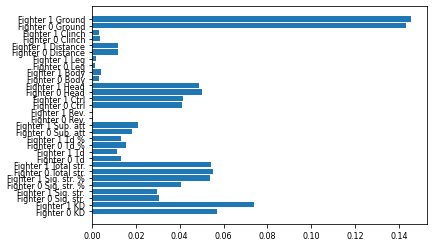

In [45]:
import matplotlib.pyplot as plt

# Visualize importances
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, clf.feature_importances_)

In [46]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/home/tylerlum/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy_train = 0.8833648393194707
accuracy_valid = 0.8434382194934766


In [47]:
# SVM
from sklearn.svm import SVC

clf = SVC(random_state=1).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/home/tylerlum/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy_train = 0.8196597353497165
accuracy_valid = 0.8081350729086723


In [48]:
# FFN
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=X_train.shape[1:]))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

/home/tylerlum/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


/home/tylerlum/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorboard/co

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Train on 5290 samples, validate on 2606 samples
Epoch 1/100
5290/5290 [==============================] - 0s 59us/sample - loss: 1.7022 - acc: 0.7051 - val_loss: 0.9448 - val_acc: 0.7640
Epoch 2/100
5290/5290 [==============================] - 0s 35us/sample - loss: 0.6704 - acc: 0.7715 - val_loss: 0.7094 - val_acc: 0.7548
Epoch 3/100
5290/5290 [==============================] - 0s 35us/sample - loss: 0.5545 - acc: 0.7769 - val_loss: 0.7752 - val_acc: 0.7563
Epoch 4/100
5290/5290 [==============================] - 0s 35us/sample - loss: 0.4701 - acc: 0.7943 - val_loss: 0.7248 - val_acc: 0.7172
Epoch 5/100
5290/5290 [==============================] - 0s 39us/sample - loss: 0.4474 - acc: 0.7970 - val_loss: 0.5608 - val_acc: 0.8028
Epoch 6/100
5290/5290 [==============================] - 0s 40us/sample - loss: 0.4620 - acc: 0.7966 - val_loss: 0.5853 - val_acc: 0.7905
Epoch 7/100
5290/5290 [==============================] - 0s 38us/sample - loss: 0.4182 - acc: 0.8057 - val_loss: 0.5853 - va

5290/5290 [==============================] - 0s 37us/sample - loss: -0.4991 - acc: 0.8495 - val_loss: 1.2478 - val_acc: 0.8327
Epoch 60/100
5290/5290 [==============================] - 0s 35us/sample - loss: -0.5309 - acc: 0.8452 - val_loss: 1.3302 - val_acc: 0.8285
Epoch 61/100
5290/5290 [==============================] - 0s 36us/sample - loss: -0.6262 - acc: 0.8476 - val_loss: 1.4372 - val_acc: 0.8070
Epoch 62/100
5290/5290 [==============================] - 0s 37us/sample - loss: -0.7484 - acc: 0.8493 - val_loss: 1.6063 - val_acc: 0.7947
Epoch 63/100
5290/5290 [==============================] - 0s 35us/sample - loss: -0.8113 - acc: 0.8503 - val_loss: 1.6059 - val_acc: 0.8239
Epoch 64/100
5290/5290 [==============================] - 0s 35us/sample - loss: -1.0553 - acc: 0.8505 - val_loss: 2.2081 - val_acc: 0.8131
Epoch 65/100
5290/5290 [==============================] - 0s 35us/sample - loss: -1.1073 - acc: 0.8484 - val_loss: 2.2046 - val_acc: 0.8404
Epoch 66/100
5290/5290 [=========

In [51]:
model.evaluate(X_train, y_train)
model.evaluate(X_valid, y_valid)

2606/2606 [==============================] - 0s 12us/sample - loss: 18.8273 - acc: 0.8193


[18.827257774924647, 0.8192632]

## Test out model manually

In [52]:
idx = 6

In [53]:
X_test.iloc[idx]

Fighter 0 KD              0.0
Fighter 1 KD              0.0
Fighter 0 Sig. str.      57.0
Fighter 1 Sig. str.      48.0
Fighter 0 Sig. str. %    48.0
Fighter 1 Sig. str. %    55.0
Fighter 0 Total str.     81.0
Fighter 1 Total str.     61.0
Fighter 0 Td              0.0
Fighter 1 Td              0.0
Fighter 0 Td %            0.0
Fighter 1 Td %            0.0
Fighter 0 Sub. att        2.0
Fighter 1 Sub. att        0.0
Fighter 0 Rev.            0.0
Fighter 1 Rev.            0.0
Fighter 0 Ctrl           44.0
Fighter 1 Ctrl           65.0
Fighter 0 Head           18.0
Fighter 1 Head           17.0
Fighter 0 Body           10.0
Fighter 1 Body            9.0
Fighter 0 Leg            29.0
Fighter 1 Leg            22.0
Fighter 0 Distance       55.0
Fighter 1 Distance       48.0
Fighter 0 Clinch          0.0
Fighter 1 Clinch          0.0
Fighter 0 Ground          2.0
Fighter 1 Ground          0.0
Name: 170, dtype: float64

In [54]:
# 0 means fighter 0 won. 1 means fighter 1 won.
y_test.iloc[idx]

Winner    0
Name: 170, dtype: int64

In [55]:
X_test.shape

(3890, 30)

In [56]:
X_test.iloc[idx].shape

(30,)

In [57]:
model.predict(np.expand_dims(X_test.iloc[idx], 0))

array([[0.00132455]], dtype=float32)

## Save data

Store beginning file parameters.
Use current date and time to save files uniquely.

In [58]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")
print("dt_string =", dt_string)	

dt_string = 22-04-2021_11:08:22


In [59]:
parameters_string = f"NUM_EVENTS_{NUM_EVENTS_INPUT}_DATA_MODE_{DATA_MODE_INPUT}"
print("parameters_string =", parameters_string)	

parameters_string = NUM_EVENTS_All_DATA_MODE_Summary


In [60]:
import pickle
filename1 = f"FULL_FIGHT_TABLE_{parameters_string}_{dt_string}.csv"
filename2 = f"FIGHT_TABLE_{parameters_string}_{dt_string}.csv"
filename3 = f"ALL_FIGHTERS_{parameters_string}_{dt_string}.csv"
filename4 = f"RAW_FIGHT_TABLES_LIST_{parameters_string}_{dt_string}.pkl"
print(f"Saving to {filename1} and {filename2} and {filename3} and {filename4}")
FULL_FIGHT_TABLE.to_csv(filename1, index=False)
FIGHT_TABLE.to_csv(filename2, index=False)
ALL_FIGHTERS.to_csv(filename3, index=False)
with open(filename4, 'wb') as handle:
    pickle.dump(RAW_FIGHT_TABLES_LIST, handle, protocol=pickle.HIGHEST_PROTOCOL)

Saving to FULL_FIGHT_TABLE_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.csv and FIGHT_TABLE_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.csv and ALL_FIGHTERS_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.csv and RAW_FIGHT_TABLES_LIST_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.pkl


In [61]:
new = pd.read_csv(filename1)

In [62]:
new

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,...,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,...,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,...,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,...,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,...,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11781,0,2,16,24,33.0,68.0,31,49,1,0,...,0,12,7,17,4,4,5,3,1,KO/TKO Punch
11782,0,0,24,19,55.0,55.0,145,95,2,1,...,2,5,1,4,23,15,0,0,1,S-DEC
11783,0,0,13,14,19.0,35.0,15,30,0,3,...,0,3,12,11,1,0,0,3,1,U-DEC
11784,0,0,3,9,60.0,56.0,11,17,0,1,...,0,2,0,2,3,5,0,2,1,SUB Guillotine Choke


In [66]:
with open(filename4, 'rb') as pickle_file:
    new2 = pickle.load(pickle_file)

In [68]:
len(new2[0])

4